Step 1: Load Libraries and Data

In [129]:
#Import packages
import numpy as np
import pandas as pd

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

In [130]:
# File paths
tsv_file = '/Users/simonenkel/Desktop/Eye Tracking/2024SoSe_EyeTracking/Lab/Participant_data_old/jakob8.tsv'
#log_file = '.\\Participant_data/subject-Claudius_log.txt'
#csv_file = '.\\Participant_data/subject-Claudius.csv'

# Load the data
data_tsv = pd.read_csv(tsv_file, sep='\t')
#data_csv = pd.read_csv(csv_file)

In [131]:

# #import CSV
# # loop to define,and append the variables into a list.
# df = []
# amt = 4 # The amount of properly labeled tsv files
# for n in range(amt):
#     #d = pd.read_csv(fr'.\\subject-{n+1}.tsv', sep='\t')
#     d = pd.read_csv(fr'.\\Participant_data/subject-Claudius.tsv', sep='\t')
#     #F-strings ('f' before the opening quotation mark) provide a way to embed variables and expressions directly within strings.  
#     df.append(d)
#     #If you want to call subject3 (df3), you can call df[3], if you want df5, call df[5], etc.
#     # Test whether data_tsv is a Pandas dataFrame
#     assert isinstance(df[n], pd.dataFrame) == True

In [132]:
# # Sample subject to visualize (you can change this)
# subject_index = 0  # For example 2, to visualize subject 3

# # Select the relevant data_tsvFrame
# data_tsv = df[subject_index]

In [133]:
#display 5 rows of 1st participant
data_tsv.head()
#TODO BPOGX raw data, FPOGX average (used for fixation of eyetracker)

,CNT,TIME,TIME_TICK,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPOGX,...,LPUPILV,REYEX,REYEY,REYEZ,RPUPILD,RPUPILV,CX,CY,CS,USER
0,24044,389.99109,86428102589,0.00000,0.00000,389.55438,0.25848,562,0,0.44081,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,START_TRIAL
1,24045,390.00714,86428262893,0.00000,0.00000,389.55438,0.25848,562,0,0.44081,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,NaN
2,24046,390.02353,86428426762,0.50845,0.34283,389.55438,0.25848,562,0,0.50078,...,1,0.03819,0.02135,0.57628,0.00527,1,-0.47656,0.52778,0,NaN
3,24047,390.03931,86428584772,0.51052,0.34350,389.55438,0.25848,562,0,0.51642,...,1,0.03819,0.02135,0.57628,0.00525,1,-0.47656,0.52778,0,NaN
4,24048,390.05557,86428747409,0.51120,0.34290,389.55438,0.25848,562,0,0.51642,...,1,0.03933,0.02200,0.59138,0.00526,1,-0.47656,0.52778,0,NaN


In [134]:
#data_csv.head(5)
print(data_tsv)

        CNT       TIME    TIME_TICK    FPOGX    FPOGY      FPOGS    FPOGD  \
0     24044  389.99109  86428102589  0.00000  0.00000  389.55438  0.25848   
1     24045  390.00714  86428262893  0.00000  0.00000  389.55438  0.25848   
2     24046  390.02353  86428426762  0.50845  0.34283  389.55438  0.25848   
3     24047  390.03931  86428584772  0.51052  0.34350  389.55438  0.25848   
4     24048  390.05557  86428747409  0.51120  0.34290  389.55438  0.25848   
...     ...        ...          ...      ...      ...        ...      ...   
5407  29451  477.44785  87302670011  0.34208  0.33134  476.67172  0.77612   
5408  29452  477.46414  87302832883  0.34189  0.33204  476.67172  0.79242   
5409  29453  477.48016  87302993334  0.34097  0.33202  476.67172  0.80844   
5410  29454  477.49634  87303155095  0.34004  0.33187  476.67172  0.82462   
5411  29455  477.51263  87303317919  0.33923  0.33155  476.67172  0.84091   

      FPOGID  FPOGV    LPOGX  ...  LPUPILV    REYEX    REYEY    REYEZ  \
0 

Step 2: Fixation detection Algorithm + Counting left/right, up/down + counting Coordinates (most near Coordinates of the first Fixation after 'show_stimulus')

Coordinates:
COORDINATES:(-320,0, 320, 0)      
COORDINATES:(-277,-160, 277, 160) 
COORDINATES:(0,320, 0, -320)      
COORDINATES:(277,-160, -277, 160) 
COORDINATES:(-160,-277, 160, 277)
COORDINATES:(160,-277, -160, 277) 
(eventuell mehr nochmal in OpenSesame nachschauen)

In [158]:
#@Claudius @Simon: Hier euer Code

def dispersion(x, y):
    return (np.max(x)-np.min(x)) + (np.max(y)-np.min(y))


def i_dt(x, y, disp_t, dur_t_ms=100, smpl_freq=500):

    # compute number of samples in a time window
    dur_t_s = dur_t_ms/1000 # convert duration threshold to seconds
    dur_t = int(dur_t_s*smpl_freq)

    # initialize index
    i = 0
    fixations = {"fix_start_idx":[], "fix_end_idx":[]}

    # find the start and end of a fixation using the dispersion threshold and the time window
    while i + dur_t <= len(x):
        window_x = x.iloc[i:i+dur_t]
        window_y = y.iloc[i:i+dur_t]
        disp = dispersion(window_x,window_y)

        if disp > disp_t:
            i += 1
            continue

        j = 1
        while (i + dur_t + j <= len(x)) and (dispersion(x.iloc[i:i+dur_t+j],y.iloc[i:i+dur_t+j]) <= disp_t):
            j += 1

        j -= 1

        fixations["fix_start_idx"].append(i)
        fixations["fix_end_idx"].append(i+dur_t+j-1)

        i = i + dur_t + j

    return pd.DataFrame(fixations, columns=['fix_start_idx', 'fix_end_idx']) 

# Run the fixation detection algorithm
results_disp_df = i_dt(data_tsv["FPOGX"], data_tsv["FPOGY"], disp_t=0.1, dur_t_ms=100, smpl_freq=500)
print(results_disp_df)

    fix_start_idx  fix_end_idx
0              62          112
1             133          184
2             324          390
3             591          671
4             747          857
5             950         1038
6            1039         1113
7            1148         1318
8            1381         1497
9            1531         1587
10           1645         1754
11           1865         2013
12           2058         2162
13           2243         2326
14           2413         2478
15           2586         2675
16           2741         2834
17           2962         3135
18           3226         3291
19           3393         3544
20           4126         4241
21           4325         4457
22           4714         4764
23           4803         4969
24           5040         5155
25           5359         5411


In [159]:
regions = [
    {'name': 'region1', 'bounds': (-320, 0, 320, 0)},
    {'name': 'region2', 'bounds': (-277, -160, 277, 160)},
    {'name': 'region3', 'bounds': (0, 320, 0, -320)},
    {'name': 'region4', 'bounds': (277, -160, -277, 160)},
    {'name': 'region5', 'bounds': (-160, -277, 160, 277)},
    {'name': 'region6', 'bounds': (160, -277, -160, 277)},
]

def count_fixations_in_regions(fixations, data_tsv, regions):
    counts = {region['name']: 0 for region in regions}

    for _, row in fixations.iterrows():
        mean_x = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGX'].mean()
        mean_y = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGY'].mean()

        for region in regions:
            x1, y1, x2, y2 = region['bounds']
            if x1 <= mean_x <= x2 and y1 <= mean_y <= y2:
                counts[region['name']] += 1

    return counts

fixation_counts = count_fixations_in_regions(results_disp_df, data_tsv, regions)


In [160]:
def find_first_fixation_after_event(data_tsv, fixations, event_name='START_TRIAL'):
    event_time = None
    for _, row in data_tsv.iterrows():
        if row['USER'] == event_name:
            event_time = row['TIME']
            break

    if event_time is None:
        return None

    for _, row in fixations.iterrows():
        if data_tsv.loc[row['fix_start_idx'], 'TIME'] >= event_time:
            return row

    return None

first_fixation = find_first_fixation_after_event(data_tsv, results_disp_df)


In [161]:
def find_nearest_coordinate(fixation, data_tsv, coordinates):
    if fixation is None:
        return None

    mean_x = data_tsv.loc[fixation['fix_start_idx']:fixation['fix_end_idx'], 'FPOGX'].mean()
    mean_y = data_tsv.loc[fixation['fix_start_idx']:fixation['fix_end_idx'], 'FPOGY'].mean()

    nearest_coord = None
    min_distance = float('inf')

    for coord in coordinates:
        x1, y1, x2, y2 = coord
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        distance = ((mean_x - center_x) ** 2 + (mean_y - center_y) ** 2) ** 0.5
        if distance < min_distance:
            min_distance = distance
            nearest_coord = coord

    return nearest_coord

coordinates = [
    (-320, 0, 320, 0),
    (-277, -160, 277, 160),
    (0, 320, 0, -320),
    (277, -160, -277, 160),
    (-160, -277, 160, 277),
    (160, -277, -160, 277),
]

nearest_coord = find_nearest_coordinate(first_fixation, data_tsv, coordinates)
print(nearest_coord)  # Print the nearest coordinate to verify

(-320, 0, 320, 0)


In [162]:
print("Fixation Detection Completed")
print(results_disp_df)  # Print first few rows of fixations to verify

print("Fixations Counted in Regions")
print(fixation_counts)  # Print the counts to verify

print("First Fixation After 'START_TRIAL'")
print(first_fixation)  # Print the first fixation details to verify

print("Nearest Coordinate to First Fixation")
print(nearest_coord)  # Print the nearest coordinate to verify

Fixation Detection Completed
    fix_start_idx  fix_end_idx
0              62          112
1             133          184
2             324          390
3             591          671
4             747          857
5             950         1038
6            1039         1113
7            1148         1318
8            1381         1497
9            1531         1587
10           1645         1754
11           1865         2013
12           2058         2162
13           2243         2326
14           2413         2478
15           2586         2675
16           2741         2834
17           2962         3135
18           3226         3291
19           3393         3544
20           4126         4241
21           4325         4457
22           4714         4764
23           4803         4969
24           5040         5155
25           5359         5411
Fixations Counted in Regions
{'region1': 0, 'region2': 26, 'region3': 0, 'region4': 0, 'region5': 26, 'region6': 0}
First Fixation Aft

In [163]:
def count_fixations_in_coordinate_pairs(fixations, data_tsv, coordinates):
    counts = {
        'oben_links': 0,
        'oben_rechts': 0,
        'unten_links': 0,
        'unten_rechts': 0,
        'diagonal_links': 0,
        'diagonal_rechts': 0,
    }

    for _, row in fixations.iterrows():
        mean_x = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGX'].mean()
        mean_y = data_tsv.loc[row['fix_start_idx']:row['fix_end_idx'], 'FPOGY'].mean()

        for coord in coordinates:
            x1, y1, x2, y2 = coord
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2

            if mean_y <= center_y:  # oben
                if mean_x <= center_x:  # links
                    counts['oben_links'] += 1
                else:  # rechts
                    counts['oben_rechts'] += 1
            else:  # unten
                if mean_x <= center_x:  # links
                    counts['unten_links'] += 1
                else:  # rechts
                    counts['unten_rechts'] += 1

            # Check diagonal conditions
            if (mean_x - center_x) * (mean_y - center_y) < 0:  # diagonal
                if mean_x <= center_x:  # links
                    counts['diagonal_links'] += 1
                else:  # rechts
                    counts['diagonal_rechts'] += 1

    return counts

# Beispiel für Koordinaten (bitte entsprechend anpassen, falls notwendig)
coordinates = [
    (-320, 0, 320, 0),     # horizontal zentriert
    (-277, -160, 277, 160), # horizontal in der Mitte
    (0, 320, 0, -320),     # vertikal zentriert
    (277, -160, -277, 160), # vertikal in der Mitte
    (-160, -277, 160, 277), # diagonal links unten
    (160, -277, -160, 277), # diagonal rechts oben
]

# Annahme: results_disp_df ist ein DataFrame mit den Ergebnissen der Fixation Detection
# und data_tsv ist der ursprüngliche DataFrame mit den Eyetracking-Daten

# Zähle Fixierungen in Paaren von Koordinatenbereichen
pair_fixation_counts = count_fixations_in_coordinate_pairs(results_disp_df, data_tsv, coordinates)

# Drucke die Zählungen für jedes Paar
print("Fixierungen gezählt in Paaren von Koordinatenbereichen")
print(pair_fixation_counts)




Fixierungen gezählt in Paaren von Koordinatenbereichen
{'oben_links': 0, 'oben_rechts': 0, 'unten_links': 0, 'unten_rechts': 156, 'diagonal_links': 0, 'diagonal_rechts': 0}


(Step 2: Load and Parse Log Data (irrelevant))

In [141]:
# # Load log data
# with open(log_file, 'r') as file:
#     log_data = file.readlines()

# # Parse log data
# logs = []
# for line in log_data:
#     if "start_trial" in line or "stop_trial" in line or "coordinates" in line:
#         logs.append(line.strip())
        
# # Create DataFrame for logs
# log_df = pd.DataFrame(logs, columns=['log'])

# # Function to extract timestamps and other details from logs
# def extract_log_details(log_df):
#     events = []
#     for index, row in log_df.iterrows():
#         if "start_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'start_trial'})
#         elif "stop_trial" in row['log']:
#             events.append({'timestamp': index, 'event': 'stop_trial'})
#         elif "coordinates" in row['log']:
#             coords = row['log'].split(':')[1].strip()
#             events.append({'timestamp': index, 'event': 'coordinates', 'coords': coords})
#     return pd.DataFrame(events)

# # Extracting log details
# log_events = extract_log_details(log_df)
# log_events.head()

Step 3: Different Plots

Step 3.1: Distribution of FPOGX

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


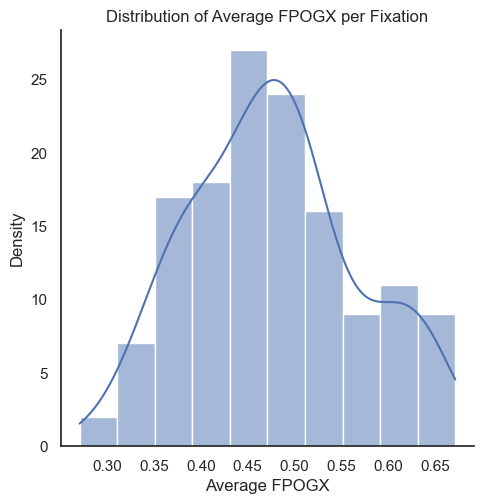

In [142]:
df_fixations = data_tsv.groupby('FPOGID')['FPOGX'].mean().reset_index()

# Plot the distribution using seaborn's displot
sns.displot(df_fixations, x='FPOGX', kde=True) 
plt.title('Distribution of Average FPOGX per Fixation')
plt.xlabel('Average FPOGX')
plt.ylabel('Density')
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


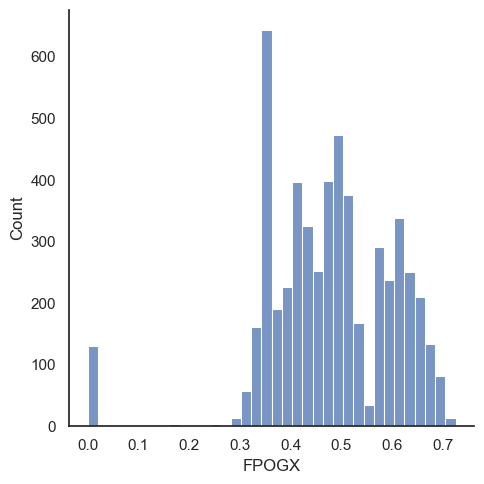

In [143]:
#test the dataset with a displot
#Use FPOGID instead of count to get Valid Counts (One fixation gets many counts)
sns.displot(data_tsv, x='FPOGX')

Step 3.2: Plot Time Against X-Position with Vertical Lines for Each User Log/Trigger

In [144]:
# Filter the data_tsv for different event types
fixation_points = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']
start_trial_points = data_tsv[data_tsv['USER'] == 'START_TRIAL']
stop_trial_points = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']
stimuli_points = data_tsv[data_tsv['USER'] == 'HIDE_STIMULUS']
coordinates_points = data_tsv[data_tsv['USER'] == 'COORDINATES']

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


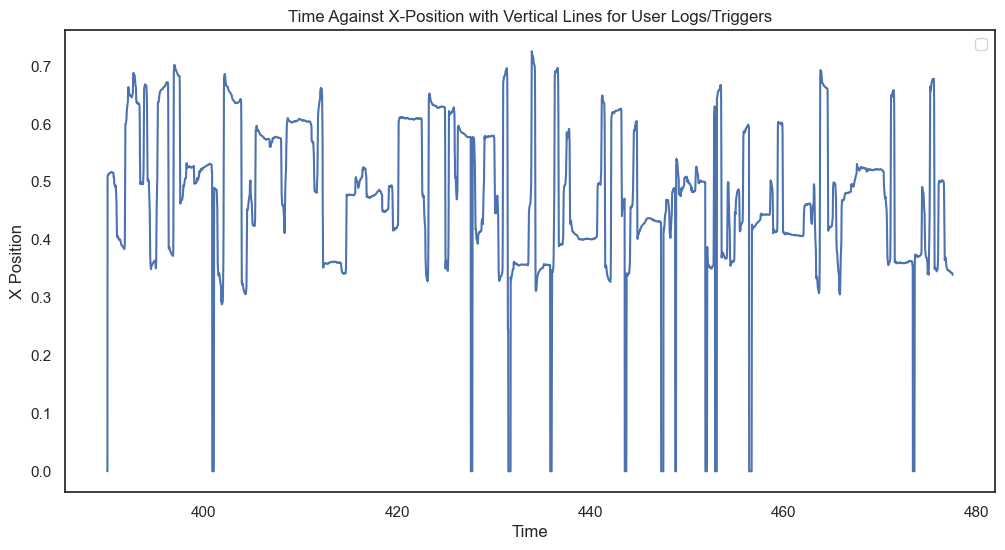

In [145]:

# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
#plt.xlim(3500, 3600)

# Filter the data_tsv for different event types
fixation_times = data_tsv[data_tsv['USER'] == 'SHOW_STIMULUS']['TIME']
start_trial_times = data_tsv[data_tsv['USER'] == 'HIDE_STIMULUS']['TIME']
stop_trial_times = data_tsv[data_tsv['USER'] == 'STOP_TRIAL']['TIME']
stimuli_times = data_tsv[data_tsv['USER'] == 'STIMULI']['TIME']
coordinates_times = data_tsv[data_tsv['USER'] == 'COORDINATES']['TIME']

# Add vertical lines for each event type
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--', label='Fixation' if fixation_time == fixation_times.iloc[0] else "")
for start_trial_time in start_trial_times:
    plt.axvline(x=start_trial_time, color='b', linestyle='--', label='Start Trial' if start_trial_time == start_trial_times.iloc[0] else "")
for stop_trial_time in stop_trial_times:
    plt.axvline(x=stop_trial_time, color='g', linestyle='--', label='Stop Trial' if stop_trial_time == stop_trial_times.iloc[0] else "")
for stimuli_time in stimuli_times:
    plt.axvline(x=stimuli_time, color='m', linestyle='--', label='Stimuli' if stimuli_time == stimuli_times.iloc[0] else "")
for coordinates_time in coordinates_times:
    plt.axvline(x=coordinates_time, color='y', linestyle='--', label='Coordinates' if coordinates_time == coordinates_times.iloc[0] else "")

# Add a legend
plt.legend()

plt.show()
#TODO: X und Y in einen Plot


In [146]:
# # **Time vs. X Plot**
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
# plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
# plt.xlabel("Time")
# plt.ylabel("X Position")

# # Add vertical lines for each user log/trigger
# for trigger_time in data_csv['time_image_stimulus']:
#  plt.axvline(x=trigger_time, color='r', linestyle='--')
# plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


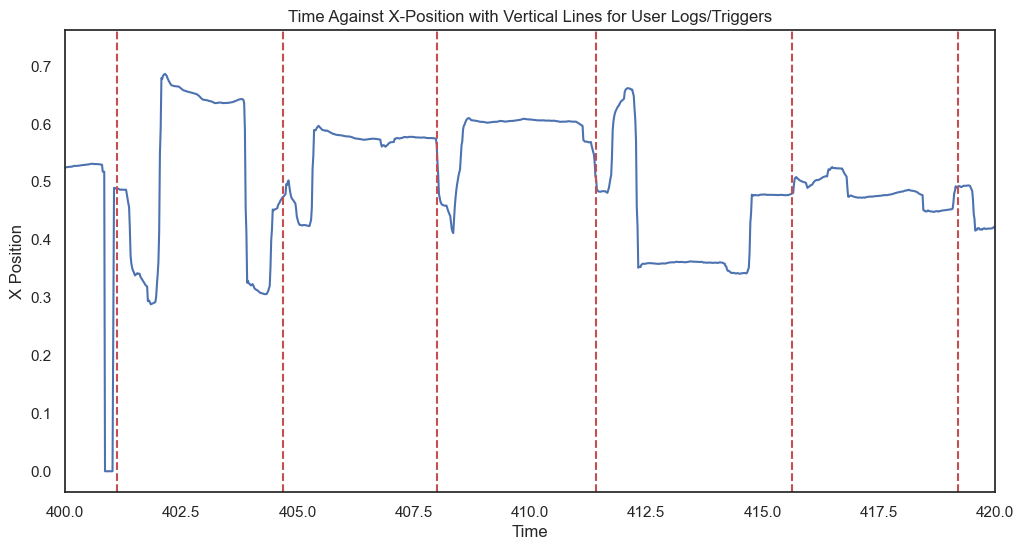

In [147]:
# **Time vs. X Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGX")
plt.title('Time Against X-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("X Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


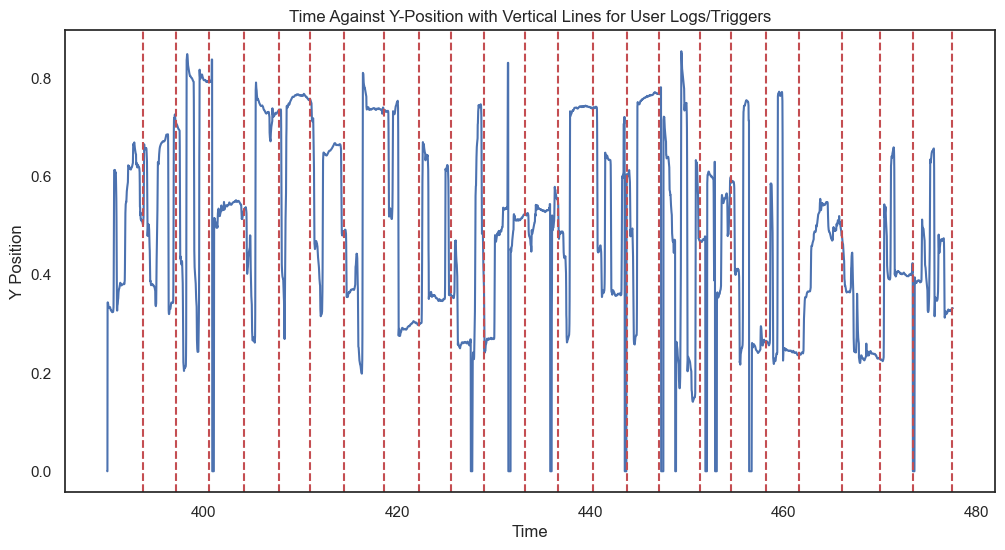

In [148]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


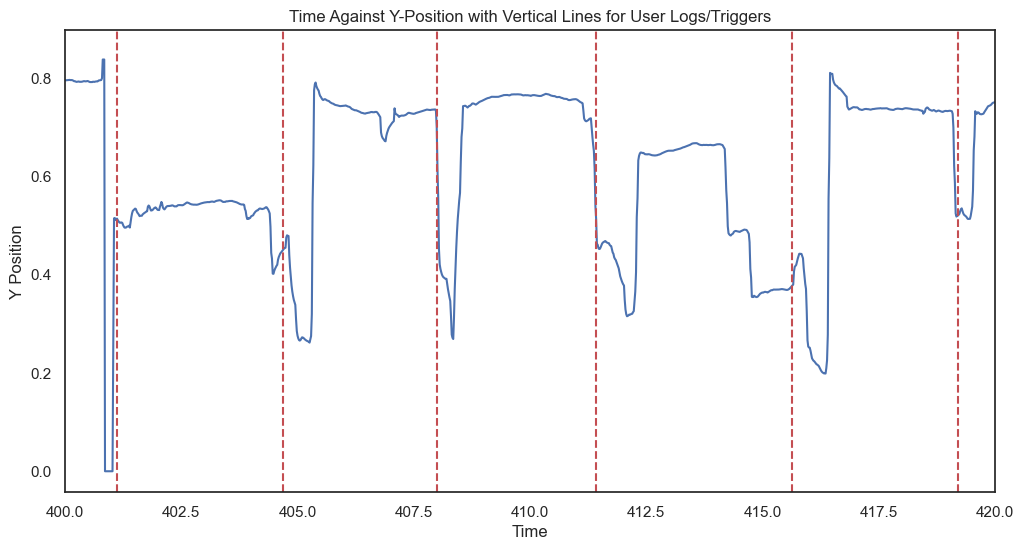

In [149]:
# **Time vs. Y Plot**
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
plt.title('Time Against Y-Position with Vertical Lines for User Logs/Triggers')
plt.xlabel("Time")
plt.ylabel("Y Position")
plt.xlim(400, 420)
# Filter the data_tsv for rows where USER column is 'FIXATION'
fixation_times = data_tsv[data_tsv['USER'] == 'FIXATION_STIMULUS']['TIME']

# Add vertical lines for each fixation time
for fixation_time in fixation_times:
    plt.axvline(x=fixation_time, color='r', linestyle='--')
plt.show()

In [150]:
# # **Time vs. Y Plot** zoom in
# sns.lineplot(data=data_tsv, x="TIME", y="FPOGY")
# # Zoom in on the x-axis between 0.6 and 0.7
# plt.xlim(3550, 3600)
# plt.title(f"Subject {subject_index + 1} - Y Position over Time")
# plt.xlabel("Time")
# plt.ylabel("Y Position")
# plt.show()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


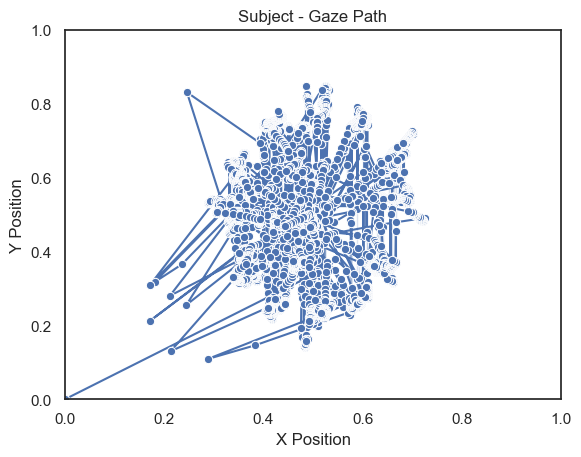

In [151]:
# **X vs. Y Plot (Gaze Path)**
#sns.scatterplot(data_tsv=data_tsv, x="FPOGX", y="FPOGY", s=40, hue='FPOGID')  # Use scatterplot for gaze path
sns.lineplot(data=data_tsv, x="FPOGX", y="FPOGY", marker='o', sort =False)  # Use scatterplot for gaze path
# Zoom in on the x-axis between 0.6 and 0.7

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


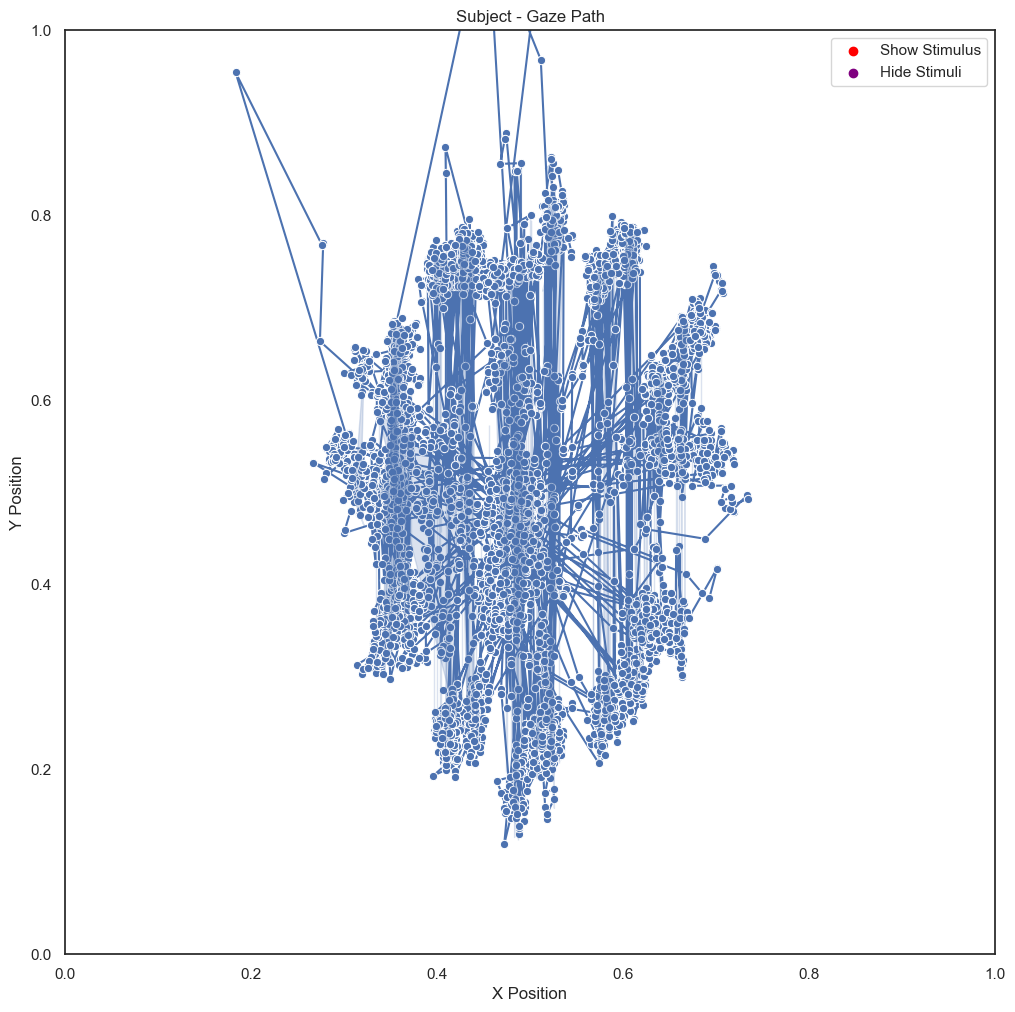

In [152]:


# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 12))
sns.lineplot(data=data_tsv, x="BPOGX", y="BPOGY", marker='o', sort=False, zorder=1)

# Add scatter plots for different event types
plt.scatter(fixation_points["BPOGX"], fixation_points["BPOGY"], color='red', label='Show Stimulus', zorder=2)
# plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
# plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Hide Stimuli', zorder=8)
# plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject - Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()


In [153]:

# Function to get time frames for FIXATION_STIMULUS
def get_fixation_stimulus_time_frames(data):

    if fixation_points.empty:
        return []
    time_frames = []
    fixation_points = fixation_points.sort_values(by='TIME')
    current_start = fixation_points['TIME'].iloc[0]
    current_end = current_start
    
    for time in fixation_points['TIME'].iloc[1:]:
        if time - current_end > 1:  # Assuming a gap larger than 1 second indicates a new stimulus
            time_frames.append((current_start, current_end))
            current_start = time
        current_end = time
    
    time_frames.append((current_start, current_end))
    return time_frames

# Get time frames for FIXATION_STIMULUS
time_frames = get_fixation_stimulus_time_frames(data_tsv)

# Plot data for each time frame
for start_time, end_time in time_frames:
    filtered_data = data_tsv[(data_tsv['TIME'] >= start_time) & (data_tsv['TIME'] <= end_time)]
    
    fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']
    start_trial_points = filtered_data[filtered_data['USER'] == 'START_TRIAL']
    stop_trial_points = filtered_data[filtered_data['USER'] == 'STOP_TRIAL']
    stimuli_points = filtered_data[filtered_data['USER'] == 'STIMULI']
    coordinates_points = filtered_data[filtered_data['USER'] == 'COORDINATES']

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

    # Add scatter plots for different event types
    plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
    plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
    plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
    plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
    plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

    plt.title(f"Subject Gaze Path from {start_time} to {end_time}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.show()


UnboundLocalError: cannot access local variable 'fixation_points' where it is not associated with a value

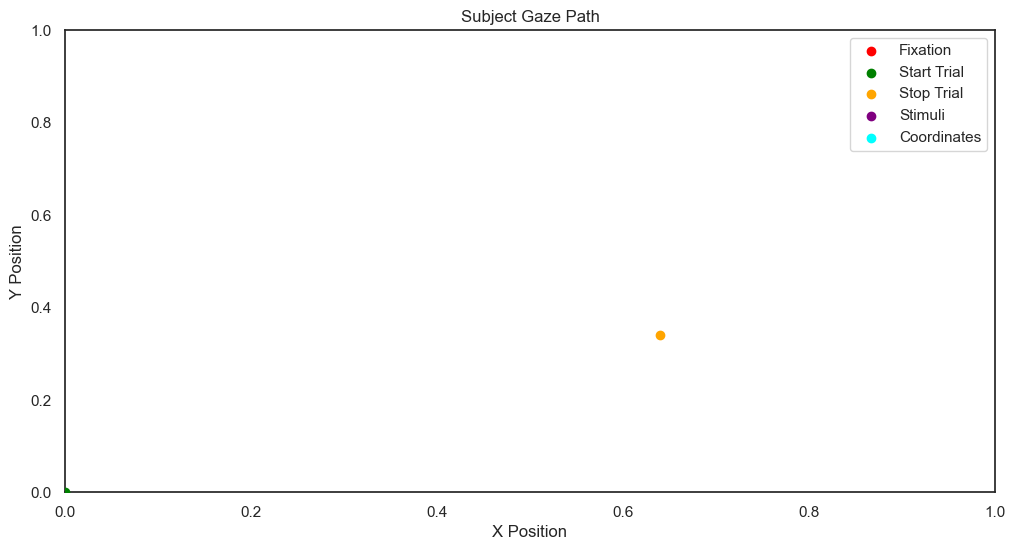

In [ ]:
# Filter the data_tsv for the specified time range
filtered_data = data_tsv[(data_tsv['TIME'] >= 3550) & (data_tsv['TIME'] <= 3600)]

# Filter the data_tsv for fixation points within the specified time range
fixation_points = filtered_data[filtered_data['USER'] == 'FIXATION']

# **X vs. Y Plot (Gaze Path)**
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x="FPOGX", y="FPOGY", marker='o', sort=False)

# Add scatter plots for different event types
plt.scatter(fixation_points["FPOGX"], fixation_points["FPOGY"], color='red', label='Fixation', zorder=5)
plt.scatter(start_trial_points["FPOGX"], start_trial_points["FPOGY"], color='green', label='Start Trial', zorder=6)
plt.scatter(stop_trial_points["FPOGX"], stop_trial_points["FPOGY"], color='orange', label='Stop Trial', zorder=7)
plt.scatter(stimuli_points["FPOGX"], stimuli_points["FPOGY"], color='purple', label='Stimuli', zorder=8)
plt.scatter(coordinates_points["FPOGX"], coordinates_points["FPOGY"], color='cyan', label='Coordinates', zorder=9)

plt.title(f"Subject Gaze Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()
#TODO Heat map 
# also put the pics in the background

Step 4: Check for Balancing/Randomization Errors

In [ ]:
def check_balancing_errors(data_tsv):
    # Count the occurrences of each unique value in the 'USER' column
    
    event_counts = data_tsv['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    
    print()  # Add a blank line for better readability

check_balancing_errors(data_tsv)
#TODO check the dtected expected values. 
# If they do not match check if they are overwriten (too short amount of time to write)

Event frequency in the 'USER' column:
USER
FIXATION_STIMULUS    24
FIXATION             24
START_TRIAL           1
STOP_TRIAL            1
Name: count, dtype: int64



Step 5: Calculate Accuracy/Precision while Gaze is on a Fixation-Cross

In [ ]:
def calculate_accuracy_precision(data_tsv):
    fixation_cross_coords = (0, 0)  # Assuming fixation cross is at the center
    
    # Filter data for fixation events of USER column with FIXATION value
    fixation_data = data_tsv[(data_tsv['USER'] == 'FIXATION')]
    
    # Calculate distances from fixation cross
    fixation_distances = np.sqrt((fixation_data['FPOGX'] - fixation_cross_coords[0])**2 + 
                                 (fixation_data['FPOGY'] - fixation_cross_coords[1])**2)
    
    accuracy = fixation_distances.mean()
    precision = fixation_distances.std()   
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")

calculate_accuracy_precision(data_tsv)


Accuracy: 0.6830318551321554
Precision: 0.07779814628210628
